#1. Data

In [2]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np

import matplotlib.pyplot as plt
import os
import PIL
import pathlib

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


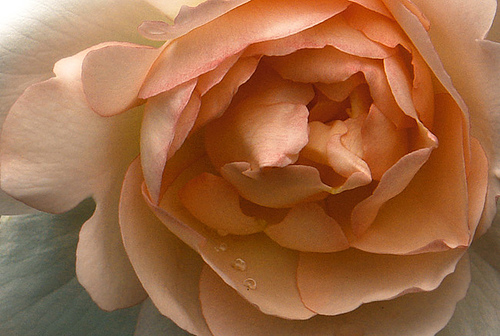

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

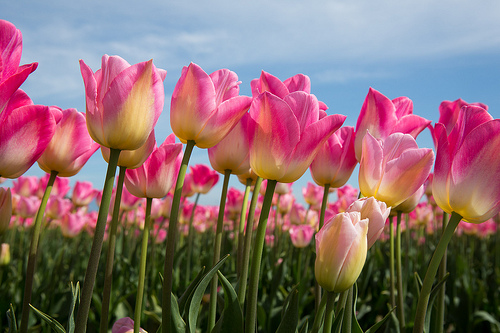

In [13]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[2]))

#2. Dataset

In [49]:
batch_size = 32
img_height = 180
img_width = 180

num_classes = 5
epochs = 15

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#3. Visualization

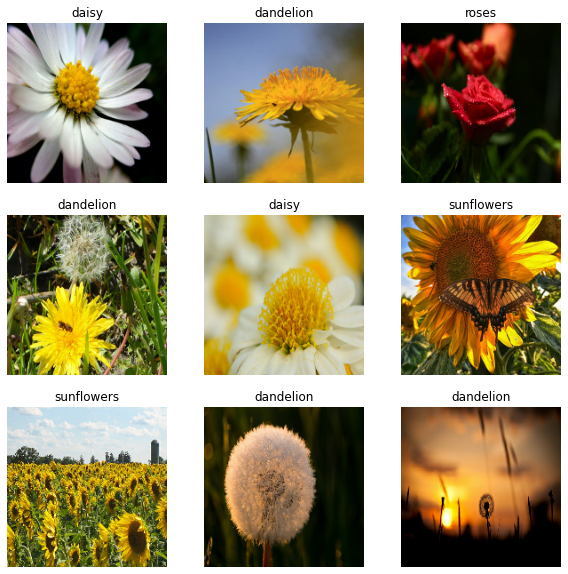

In [22]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9994159


#4. Model

In [28]:
model = keras.Sequential([
  keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [31]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10
92/92 [==============================] - 89s 958ms/step - loss: 1.4993 - accuracy: 0.3477 - val_loss: 1.0805 - val_accuracy: 0.5708
Epoch 2/10
92/92 [==============================] - 86s 937ms/step - loss: 0.9861 - accuracy: 0.6230 - val_loss: 0.9478 - val_accuracy: 0.6104
Epoch 3/10
92/92 [==============================] - 86s 935ms/step - loss: 0.7685 - accuracy: 0.7087 - val_loss: 0.8720 - val_accuracy: 0.6608
Epoch 4/10
92/92 [==============================] - 86s 936ms/step - loss: 0.5661 - accuracy: 0.7929 - val_loss: 0.9688 - val_accuracy: 0.6376
Epoch 5/10
92/92 [==============================] - 86s 936ms/step - loss: 0.3365 - accuracy: 0.8834 - val_loss: 1.1097 - val_accuracy: 0.6403
Epoch 6/10
92/92 [==============================] - 86s 940ms/step - loss: 0.1801 - accuracy: 0.9491 - val_loss: 1.1659 - val_accuracy: 0.6458
Epoch 7/10
92/92 [==============================] - 86s 936ms/step - loss: 0.1084 - accuracy: 0.9751 - val_loss: 1.3381 - val_accuracy: 0.6526

In [32]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

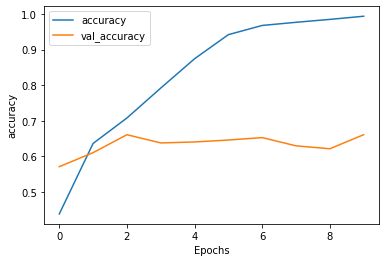

In [33]:
plot_graphs(history, 'accuracy')

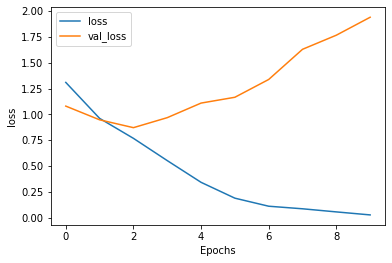

In [34]:
plot_graphs(history, 'loss')

#5. Data Augmentation

In [35]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

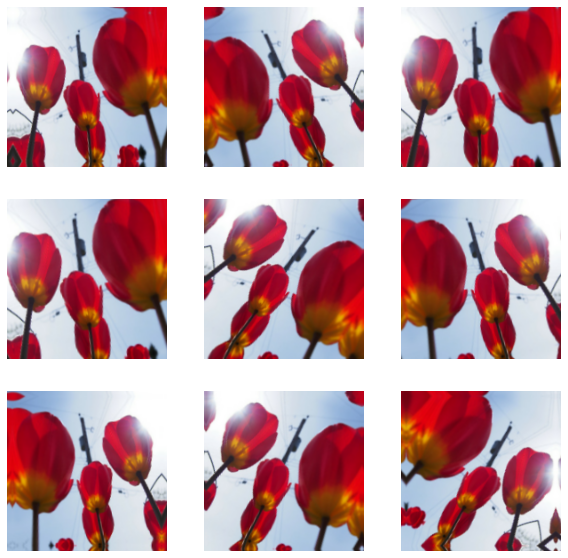

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [46]:
model = keras.Sequential([
  data_augmentation,
  keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [47]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [50]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
92/92 [==============================] - 101s 1s/step - loss: 1.6082 - accuracy: 0.3137 - val_loss: 1.0855 - val_accuracy: 0.5572
Epoch 2/15
92/92 [==============================] - 100s 1s/step - loss: 1.0980 - accuracy: 0.5571 - val_loss: 1.0337 - val_accuracy: 0.5913
Epoch 3/15
92/92 [==============================] - 100s 1s/step - loss: 0.9689 - accuracy: 0.6277 - val_loss: 0.9157 - val_accuracy: 0.6485
Epoch 4/15
92/92 [==============================] - 100s 1s/step - loss: 0.8519 - accuracy: 0.6777 - val_loss: 0.9241 - val_accuracy: 0.6403
Epoch 5/15
92/92 [==============================] - 100s 1s/step - loss: 0.8203 - accuracy: 0.6950 - val_loss: 0.8746 - val_accuracy: 0.6526
Epoch 6/15
92/92 [==============================] - 100s 1s/step - loss: 0.7526 - accuracy: 0.7117 - val_loss: 0.8040 - val_accuracy: 0.6894
Epoch 7/15
92/92 [==============================] - 100s 1s/step - loss: 0.7477 - accuracy: 0.7206 - val_loss: 0.7957 - val_accuracy: 0.6894
Epoch 8/15
92

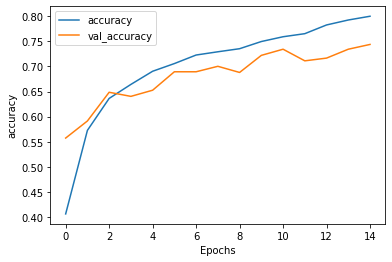

In [51]:
plot_graphs(history, 'accuracy')

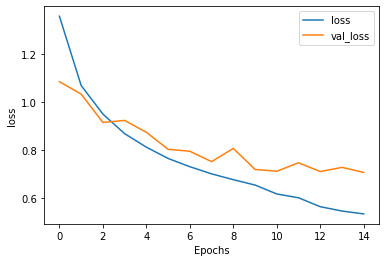

In [52]:
plot_graphs(history, 'loss')